In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from snelson_model import SnelsonMLP, adjust_learning_rate
import torch.nn as nn
import torch.optim as optim
from optim import BiNNOptimizer as BayesBiNN
from tqdm import tqdm

In [5]:
def DataLoader(data_path):
    def load_snelson(filename):
        with open(data_path + '/{fn}'.format(fn=filename), 'r') as f:
            data_temp = [float(i) for i in f.read().strip().split('\n')]
            return np.array(data_temp, dtype=np.float64).reshape(-1,1)
    
    def preprocess_snelson(X_train, y_train, X_test):
        X_train_mean, X_train_std = X_train.mean(), X_train.std()
        y_train_mean, y_train_std = y_train.mean(), y_train.std()

        X_train = (X_train-X_train_mean)/X_train_std
        y_train = (y_train-y_train_mean)/y_train_std
        X_test = (X_test-X_train_mean)/X_train_std

        return X_train, y_train, X_test

    X_train = load_snelson('train_inputs')
    y_train = load_snelson('train_outputs')
    X_test = load_snelson('test_inputs')
    perm = np.random.permutation(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]

    X_train, y_train, X_test = preprocess_snelson(X_train, y_train, X_test)
    
    return torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float(), torch.from_numpy(X_test).float()


X_train, y_train, X_test = DataLoader(data_path='./snelson data')

In [6]:
# Training Setting for STE
epochs_ste = 5000
hidden_layers_ste = [64,64]
learning_rate_ste = 0.1

# Loss Function STE
criterion_ste = nn.MSELoss()

In [7]:
torch.manual_seed(0)
np.random.seed(0)

model_ste = SnelsonMLP(X_train.shape[1], hidden_layers_ste, y_train.shape[1],
            use_bn=True, learn_bn=False, only_last_bn=True)

optimizer_ste = optim.Adam(model_ste.parameters(), lr=learning_rate_ste)

for i in range(epochs_ste):
    optimizer_ste.zero_grad()
    y_pred = model_ste.forward(X_train)
    loss = criterion_ste(y_pred, y_train)
    loss.backward()
    
    for p in list(model_ste.parameters()):
        if hasattr(p, 'org'):
            p.data.copy_(p.org)

    optimizer_ste.step()

    for p in list(model_ste.parameters()):
        if hasattr(p, 'org'):
            p.org.copy_(p.data.clamp_(-1, 1))

In [8]:
# Training settings given in the paper
hidden_layers = [64,64]
epochs = 5000
learning_rate_start = 1e-4
learning_rate_end = 1e-5
N = 1 
temperature = 1
beta = 0.99 

# Learning Rate decay
lr_decay = (learning_rate_end/learning_rate_start)**(1.0/epochs)

# Loss function
criterion = nn.MSELoss()

In [12]:
torch.manual_seed(0)
np.random.seed(0)

model = SnelsonMLP(X_train.shape[1], hidden_layers, y_train.shape[1], use_bn=True, learn_bn=False, only_last_bn=True)
optimizer = BayesBiNN(model, train_set_size=X_train.shape[0], lr=learning_rate_start, beta=beta, 
                 N=N, temperature=temperature)

for i in tqdm(range(epochs)):
    adjust_learning_rate(lr_decay, optimizer, i)
    def closure():
        optimizer.zero_grad()
        y_pred = model.forward(X_train)
        loss = criterion(y_pred, y_train)
        return loss, y_pred
    loss, y_pred = optimizer.step(closure)

100%|██████████| 5000/5000 [00:06<00:00, 758.85it/s]


In [13]:
# Get posterior mean prediction

y_pred_mean = optimizer.montecarlo_predictions(model.forward, X_test, epsilons=None)[0].detach()

torch.manual_seed(0)
np.random.seed(0)

n_samples = 10
raw_noises = []
for i in range(n_samples):        
    raw_noises.append(torch.bernoulli(torch.sigmoid(2*optimizer.state['lambda'])))
    
y_preds = optimizer.montecarlo_predictions(model.forward, X_test, raw_noises)
y_preds = torch.stack(y_preds).detach()

y_preds_mean = y_preds.mean(dim=0)
y_preds_std = y_preds.std(dim=0)


In [14]:
y_pred = model_ste.forward(X_test).detach()

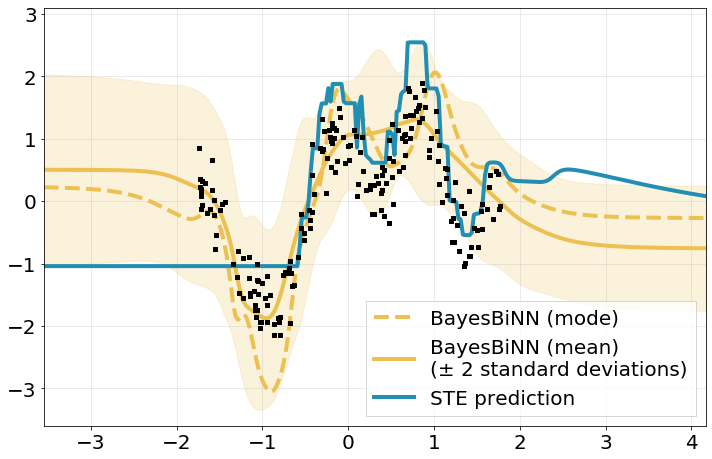

In [15]:
color2 = '#ECC152'
color1 = '#228FB2'

plt.figure(figsize=(10,6.5))

plt.scatter(X_train, y_train, s=20, c='black', marker='s', zorder=100)
plt.fill_between(X_test.flatten(), 
                 (y_preds_mean-2*y_preds_std).flatten(), 
                 (y_preds_mean+2*y_preds_std).flatten(), 
                 alpha=0.2, color=color2)
plt.plot(X_test, y_pred_mean, c=color2, ls='--', lw=4, label='BayesBiNN (mode)')
plt.plot(X_test, y_preds_mean, c=color2, lw=4, label='BayesBiNN (mean)\n(± 2 standard deviations)'.format(n_samples))
plt.plot(X_test, y_pred, c=color1, lw=4, label='STE prediction')

plt.yticks(fontsize=20, rotation=0)
plt.xticks(fontsize=20, rotation=0)
plt.xlim(X_test.min(), X_test.max())
plt.ylim(-3.6, 3.1)
plt.legend(fontsize=20, fancybox=False, loc='lower right')

plt.tight_layout()
# os.makedirs('./figs', exist_ok=True)
# plt.savefig('./figs/bb_regression_snelson.pdf', dpi=300)
plt.grid(True, alpha=0.3)
plt.show()